In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import math
from math import sqrt
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency, ttest_ind, shapiro, anderson, levene
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.power import TTestPower, TTestIndPower
import statsmodels.stats.power as smp
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy import stats

df = pd.read_csv("/Users/anthonychou/Desktop/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")

In [2]:
#Redo Data Cleaning Part from Midterm
#Drop U since it skews with our model and have only 9 observations (outliers)
df = df.drop(df[df['Sex'] == 'U'].index)
#Recode Age
df['Age_group__at_arrest_'] = df['Age_group__at_arrest_'].replace('Aged 65 and older', 'Aged 65 years and older')
df['Age_group__at_arrest_'] = df['Age_group__at_arrest_'].replace('Aged 17 years and under', 'Aged 17 years and younger')
#Organizing crimes into Assualt, Aggrevated Assault, Non Violence, Compliance and others
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Assault & Other crimes against persons', 'Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Drug Related', 'Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Harassment/Threatening', 'Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Harassment & Threatening', 'Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Break & Enter', 'Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Break and Enter', 'Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Robbery/Theft', 'Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Robbery & Theft', 'Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Weapons', 'Aggrevated Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Weapons & Homicide', 'Aggrevated Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Sexual Related Crime', 'Aggrevated Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Sexual Related Crimes & Crimes Against Children', 'Aggrevated Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Homicide', 'Aggrevated Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Crimes against Children', 'Aggrevated Assault')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Vehicle Related', 'Vehicle Related (inc. Impaired)')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Impaired', 'Vehicle Related (inc. Impaired)')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('FTA/FTC/Compliance Check/Parollee', 'Compliance')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('FTA/FTC, Compliance Check & Parollee', 'Compliance')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Police Category - Administrative', 'Compliance')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Other Statute & Other Incident Type', 'Compliance')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Other Offence', 'Compliance')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('LLA', 'Compliance')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Police Category - Incident', 'Compliance')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Mischief', 'Mischief & Fraud')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Fraud', 'Mischief & Fraud')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Mental Health', 'Other Statute')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Assault', 'Violent')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Aggrevated Assault', 'Violent')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Vehicle Related (inc. Impaired)','Not Violent')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Compliance','Not Violent')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Mischief & Fraud','Not Violent')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Other Statute','Not Violent')
df['Occurrence_Category'] = df['Occurrence_Category'].replace('Warrant','Not Violent')

#Recode so that if Searched then Booked (Input Error)
df.loc[df["StripSearch"] == 1, "Booked"] = 1

#Record to satisfy increment & interger need of analysis
df.loc[df['Age_group__at_arrest_'] == 'Aged 17 years and younger', 'Age'] = 1
df.loc[df['Age_group__at_arrest_'] == 'Aged 18 to 24 years', 'Age'] = 2
df.loc[df['Age_group__at_arrest_'] == 'Aged 25 to 34 years', 'Age'] = 3
df.loc[df['Age_group__at_arrest_'] == 'Aged 35 to 44 years', 'Age'] = 4
df.loc[df['Age_group__at_arrest_'] == 'Aged 45 to 54 years', 'Age'] = 5
df.loc[df['Age_group__at_arrest_'] == 'Aged 55 to 64 years', 'Age'] = 6
df.loc[df['Age_group__at_arrest_'] == 'Aged 65 years and older', 'Age'] = 7

#Recode for Gender
df.loc[df['Sex'] == 'F', 'Gender'] = 0
df.loc[df['Sex'] == 'M', 'Gender'] = 1

#Recode for months
df.loc[df['Arrest_Month'] == 'Jan-Mar', 'Quarter'] = 1
df.loc[df['Arrest_Month'] == 'Apr-June', 'Quarter'] = 2
df.loc[df['Arrest_Month'] == 'July-Sept', 'Quarter'] = 3
df.loc[df['Arrest_Month'] == 'Oct-Dec', 'Quarter'] = 4

#
cols_to_sum = ['Actions_at_arrest___Concealed_i', 'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d', 'Actions_at_arrest___Mental_inst', 'Actions_at_arrest___Assaulted_o']
mask = (df[cols_to_sum] == 1)
resisted_count = mask.sum(axis=1)
df['Resisted_Arrest'] = resisted_count

##Total bookings of an individual person id in period
df['Booked_Sum'] = df.groupby('PersonID')['Booked'].transform('sum')

##turn race into visible minority
df.loc[df['Perceived_Race'] == 'EastSouthEast Asian', 'Visible_Minority'] = 1
df.loc[df['Perceived_Race'] == 'South Asian', 'Visible_Minority'] = 1
df.loc[df['Perceived_Race'] == 'Latino', 'Visible_Minority'] = 1
df.loc[df['Perceived_Race'] == 'Middle Eastern', 'Visible_Minority'] = 1
df.loc[df['Perceived_Race'] == 'White', 'Visible_Minority'] = 0
df.loc[df['Perceived_Race'] == 'Black', 'Visible_Minority'] = 1
df.loc[df['Perceived_Race'] == 'Indigenous', 'Visible_Minority'] = 0



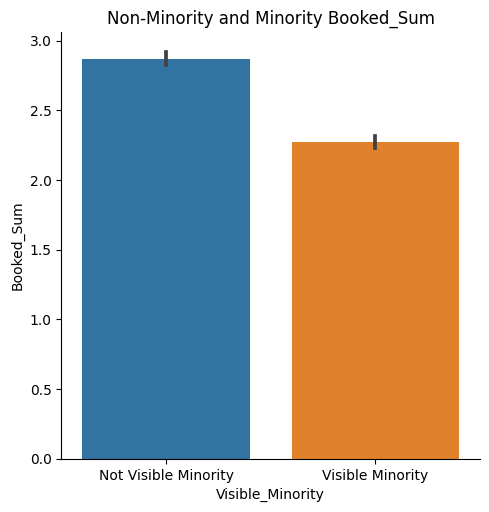

In [3]:
# Booked_Sum vs Visible_Minority
sns.catplot(x="Visible_Minority", y='Booked_Sum', kind="bar", data=df)
plt.title("Non-Minority and Minority Booked_Sum")
labels = ['Not Visible Minority', 'Visible Minority']
plt.xticks([0, 1], labels)
plt.show()


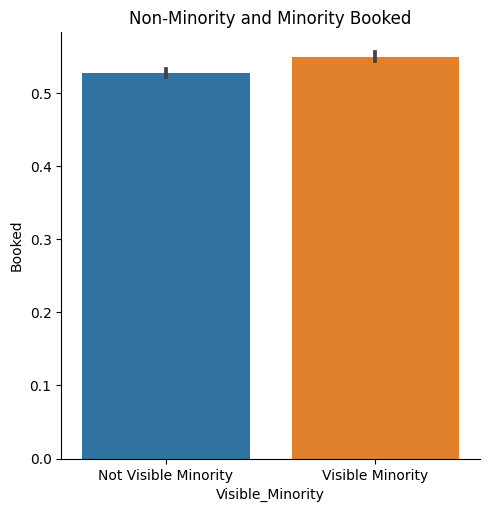

In [4]:
# Booked_Sum vs Visible_Minority
sns.catplot(x="Visible_Minority", y='Booked', kind="bar", data=df)
plt.title("Non-Minority and Minority Booked")
labels = ['Not Visible Minority', 'Visible Minority']
plt.xticks([0, 1], labels)
plt.show()


In [5]:
# Extract the 'Booked_Sum' values for both groups
visible_minority_group = df[df['Visible_Minority'] == 1]['Booked_Sum']
not_visible_minority_group = df[df['Visible_Minority'] == 0]['Booked_Sum']

# Conduct the two-sample t-test
t_stat, p_value = ttest_ind(visible_minority_group, not_visible_minority_group, equal_var=False)

# Print the results
print("t-statistic: ", t_stat)
print("p-value: ", p_value)

t-statistic:  -18.598760963822517
p-value:  5.8316053550616336e-77


<Figure size 1000x800 with 0 Axes>

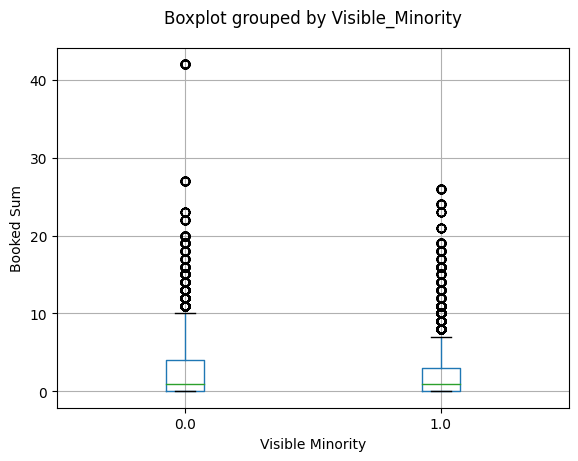

In [6]:
MinorityArrest = df[['Visible_Minority', 'Booked_Sum']]
plt.figure(figsize=(10, 8))
MinorityArrest.boxplot(by='Visible_Minority')
plt.xlabel('Visible Minority')
plt.ylabel('Booked Sum')
plt.title('')
plt.show()

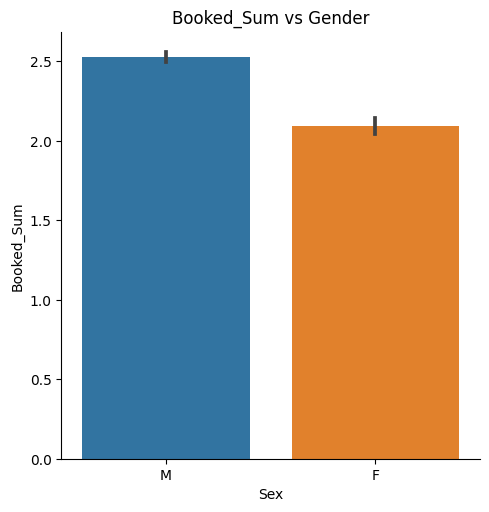

In [7]:
# Booked_Sum vs Gender
sns.catplot(x="Sex", y='Booked_Sum', kind="bar", data=df)
plt.title("Booked_Sum vs Gender")
plt.show()

In [8]:
female_group = df[df['Gender'] == 1]['Booked_Sum']
male_group = df[df['Gender'] == 0]['Booked_Sum']
t_stat, p_value = ttest_ind(female_group, male_group, equal_var=False)
print("t-statistic: ", t_stat)
print("p-value: ", p_value)

t-statistic:  13.405530684497629
p-value:  8.1399423533248e-41


<Figure size 1000x800 with 0 Axes>

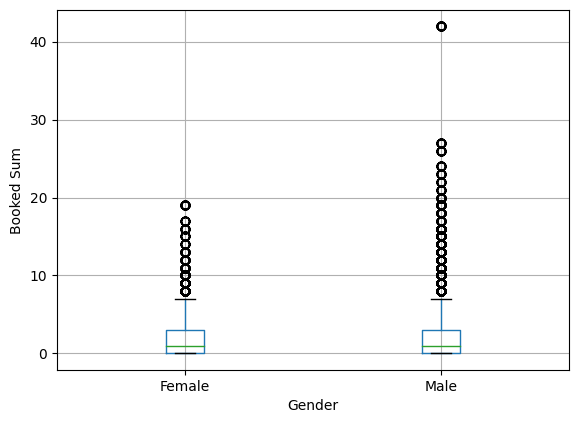

In [9]:
GenderArrest = df[['Gender', 'Booked_Sum']]
plt.figure(figsize=(10, 8))
GenderArrest.boxplot(by='Gender')
plt.xlabel('Gender')
plt.ylabel('Booked Sum')
labels = ['Female', 'Male']
plt.xticks(ticks=[1, 2], labels=labels)
plt.title('')
plt.suptitle('')  
plt.show()

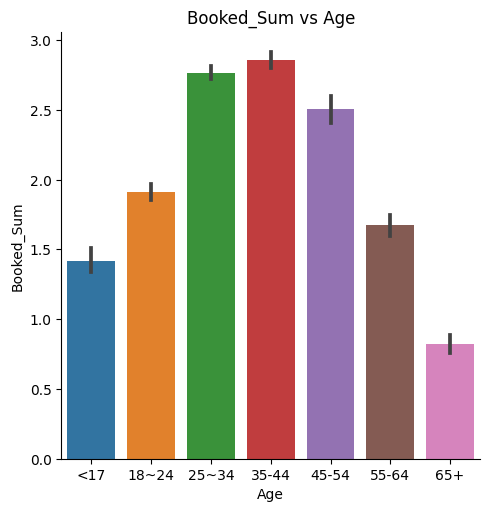

In [10]:
# Booked_Sum vs Age
sns.catplot(x="Age", y='Booked_Sum', kind="bar", data=df)
plt.title("Booked_Sum vs Age")
labels = ['<17', '18~24','25~34','35-44','45-54','55-64','65+']
plt.xticks([0, 1,2,3,4,5,6], labels)
plt.show()

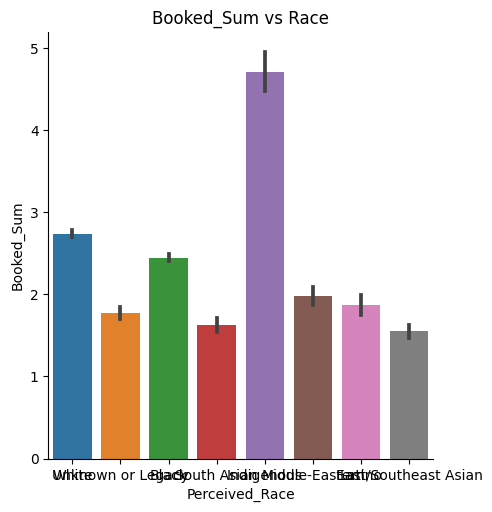

In [11]:
# Booked_Sum vs Race
sns.catplot(x="Perceived_Race", y='Booked_Sum', kind="bar", data=df)
plt.title("Booked_Sum vs Race")
plt.show()

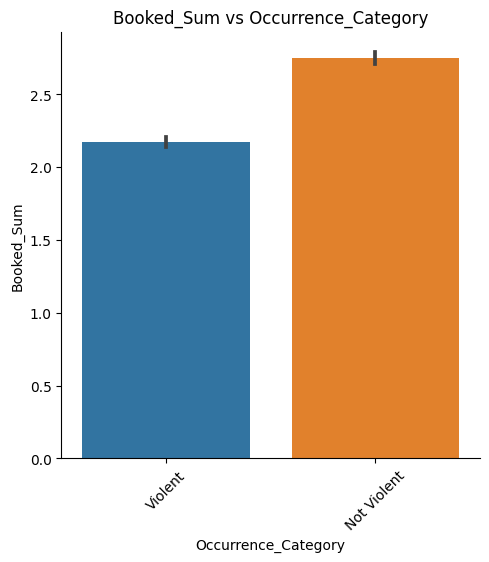

In [12]:
# Booked_Sum vs Occurrence_Category
sns.catplot(x="Occurrence_Category", y='Booked_Sum', kind="bar", data=df)
plt.title("Booked_Sum vs Occurrence_Category")
plt.xticks(rotation=45)
plt.show()

In [13]:
nonv_group = df[df['Occurrence_Category'] == 1]['Booked_Sum']
v_group = df[df['Occurrence_Category'] == 0]['Booked_Sum']
t_stat, p_value = ttest_ind(nonv_group, v_group, equal_var=False)
print("t-statistic: ", t_stat)
print("p-value: ", p_value)


t-statistic:  nan
p-value:  nan


<Figure size 1000x800 with 0 Axes>

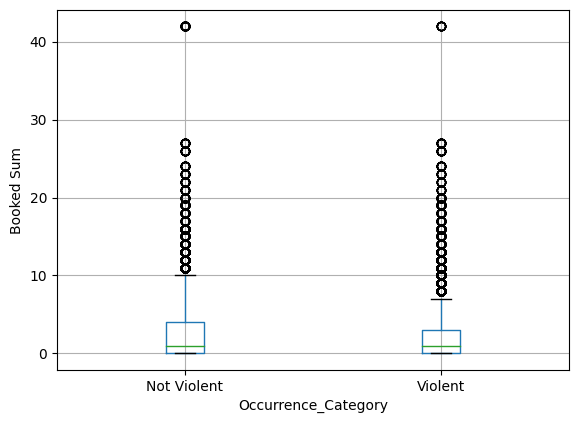

In [14]:
VArrest = df[['Occurrence_Category', 'Booked_Sum']]
plt.figure(figsize=(10, 8))
VArrest.boxplot(by='Occurrence_Category')
plt.xlabel('Occurrence_Category')
plt.ylabel('Booked Sum')
plt.title('')
plt.suptitle('') 
plt.show()

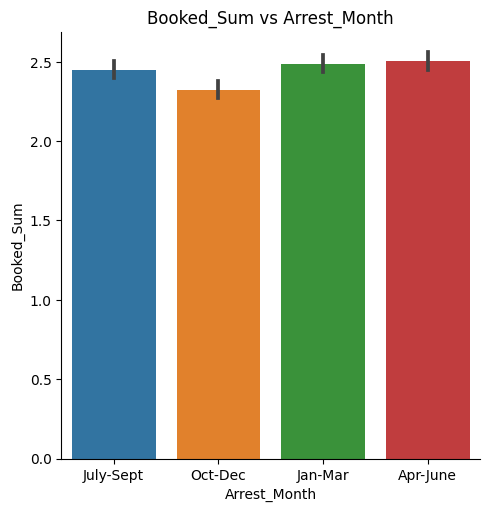

In [15]:
# Booked_Sum vs Arrest_Month
sns.catplot(x="Arrest_Month", y='Booked_Sum', kind="bar", data=df)
plt.title("Booked_Sum vs Arrest_Month")
plt.show()

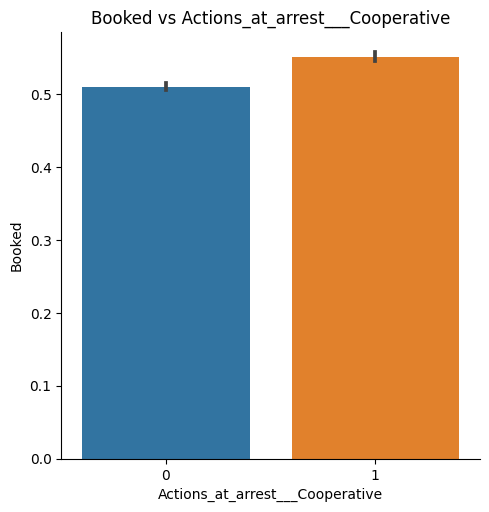

In [16]:
# Booked_Sum vs Actions_at_arrest___Cooperative
sns.catplot(x="Actions_at_arrest___Cooperative", y="Booked", kind="bar", data=df)
plt.title("Booked vs Actions_at_arrest___Cooperative")
plt.show()

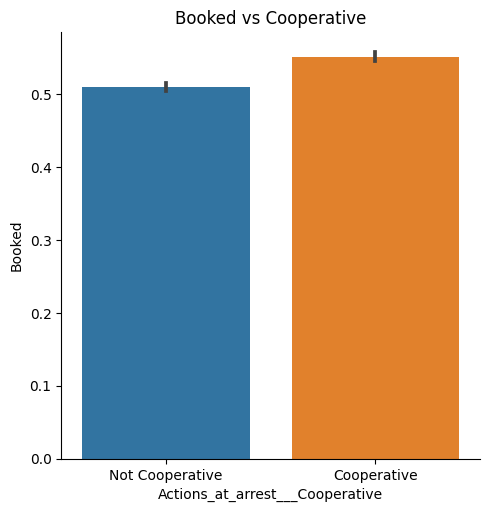

In [17]:
# Booked_Sum vs Actions_at_arrest___Cooperative
sns.catplot(x="Actions_at_arrest___Cooperative", y="Booked", kind="bar", data=df)
plt.title("Booked vs Cooperative")
labels = ['Not Cooperative', 'Cooperative']
plt.xticks([0, 1], labels)
plt.show()

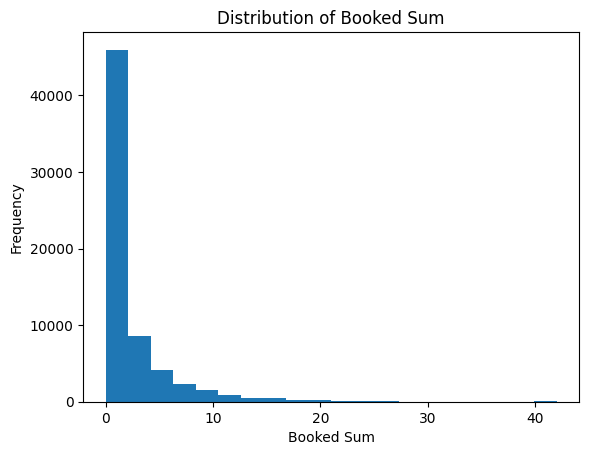

Maximum Booked Sum: 42
Minimum Booked Sum: 0


In [18]:
plt.hist(df['Booked_Sum'], bins=20)
plt.title('Distribution of Booked Sum')
plt.xlabel('Booked Sum')
plt.ylabel('Frequency')
plt.show()
print('Maximum Booked Sum:', df['Booked_Sum'].max())
print('Minimum Booked Sum:', df['Booked_Sum'].min())


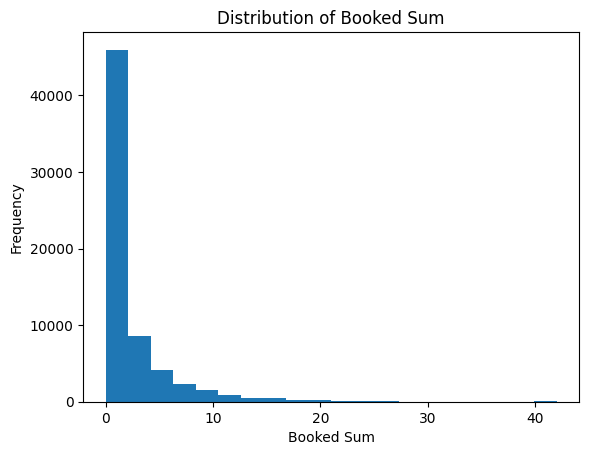

Maximum Booked Sum: 42
Minimum Booked Sum: 0


In [19]:
plt.hist(df['Booked_Sum'], bins=20)
plt.title('Distribution of Booked Sum')
plt.xlabel('Booked Sum')
plt.ylabel('Frequency')
plt.show()
print('Maximum Booked Sum:', df['Booked_Sum'].max())
print('Minimum Booked Sum:', df['Booked_Sum'].min())

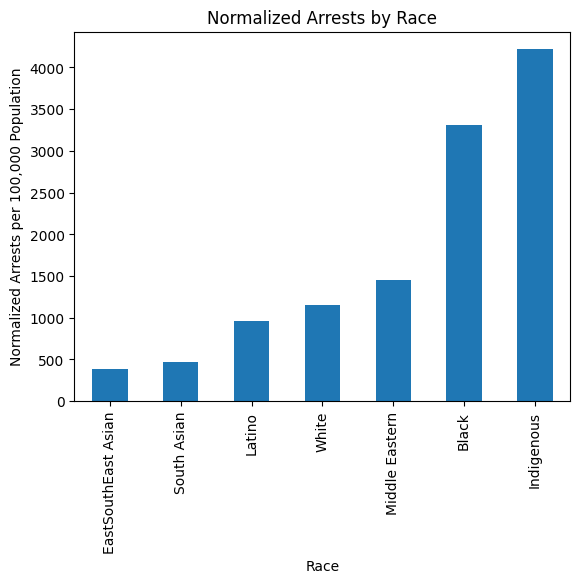

In [20]:
#Using data complied from wikipedia, we want to discover the per 100,000 person arrest rate 
Normalized_White_Arrest = (27723/1201075)*100000/2
Normalized_Black_Arrest = (17526/265005)*100000/2
Normalized_EastSouthEast_Asian_Arrest = (4415/575885)*100000/2
Normalized_South_Asian_Arrest = (3613/385440)*100000/2
Normalized_Middle_Eastern_Arrest = (3237/111360)*100000/2
Normalized_Indigenous_Arrest = (1934/22925)*100000/2
Normalized_Latino_Arrest = (1768/92455)*100000/2
#Create normalized data 
Normalized_Race_Data = {'Race': ['EastSouthEast Asian', 'South Asian', 'Latino','White', 'Middle Eastern' ,'Black', 'Indigenous'],
        'Normalized Arrests': [Normalized_EastSouthEast_Asian_Arrest, Normalized_South_Asian_Arrest, Normalized_Latino_Arrest,Normalized_White_Arrest, 
                               Normalized_Middle_Eastern_Arrest,Normalized_Black_Arrest, Normalized_Indigenous_Arrest, ]}
NRD = pd.DataFrame(Normalized_Race_Data)

normalizedplot = NRD.plot(kind='bar', x='Race', y='Normalized Arrests', legend=False)

# add labels and title
normalizedplot.set_xlabel('Race')
normalizedplot.set_ylabel('Normalized Arrests per 100,000 Population')
normalizedplot.set_title('Normalized Arrests by Race')

# show the plot
plt.show()

In [21]:
# function to calculate Cohen's d for independent samples
def pooled_standard_deviation(sample1,sample2):
    #calculate the sample size
    n1, n2 = len(sample1), len(sample2)
    #calculate the variances
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    #calculate the pooled standard deviation
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)

def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    #print(s_pooled)
    return ((u1 - u2) / s_pooled)

In [22]:
##Assumption Checks 
###Booked_Sum vs Visible Minority
#Independence of Observation
#Written
#Normality
#Total Arrest Anderson Darling Test
Visible_Minority_AD = df['Visible_Minority']
result = anderson(Visible_Minority_AD)
print('Statistic:', result.statistic)
print('Critical Values:', result.critical_values)
print('Significance Level:', result.significance_level)


#Homogeneity of Variance
# Using Levene's test to check equal variance
# Small p-value suggests not equal variance
group0 = df.loc[df['Visible_Minority'] == 0, 'Booked_Sum'].dropna()
group1 = df.loc[df['Visible_Minority'] == 1, 'Booked_Sum'].dropna()
stat, p = levene(group0, group1)
print("Levene's Test p-value:", p)


Statistic: nan
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
Levene's Test p-value: 1.6748885039233969e-77


Statistic: 20018.342950295977
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
Levene's Test p-value: 0.0


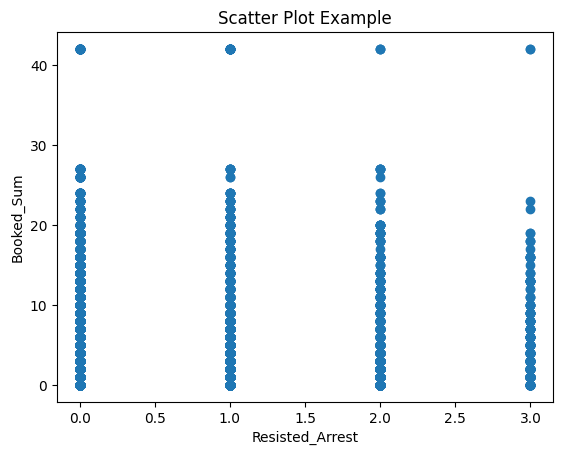

In [23]:
##Assumption Checks 
###Power Analysis 2, Booked_Sum vs Resisted_Arrest
#Independence of Observation
#Written
median_booked_sum = df['Booked_Sum'].median()
#Normality
#Total Arrest Anderson Darling Test
Visible_Minority_AD = df['Resisted_Arrest']
result = anderson(Visible_Minority_AD)
print('Statistic:', result.statistic)
print('Critical Values:', result.critical_values)
print('Significance Level:', result.significance_level)

#Homogeneity of Variance
# Using Levene's test to check equal variance
# Small p-value suggests not equal variance
group1 = df.loc[df['Booked_Sum'] <= median_booked_sum, 'Resisted_Arrest']
group2 = df.loc[df['Booked_Sum'] > median_booked_sum, 'Resisted_Arrest']
stat, p = levene(group0, group1)
print("Levene's Test p-value:", p)

#Linearity
#Homogeneity of Regression Slope

# Create a scatter plot
plt.scatter(df['Resisted_Arrest'], df['Booked_Sum'])

# Add labels and a title
plt.xlabel('Resisted_Arrest')
plt.ylabel('Booked_Sum')
plt.title('Scatter Plot Example')

# Display the scatter plot
plt.show()


Statistic: nan
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
Levene's Test p-value: nan


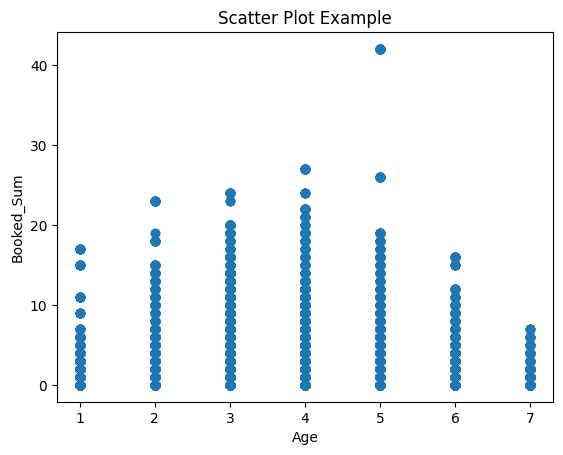

In [24]:
##Assumption Checks 
###Power Analysis 3, Booked_Sum vs Age
#Independence of Observation
#Written

#Normality
#Total Arrest Anderson Darling Test
Visible_Minority_AD = df['Age']
result = anderson(Visible_Minority_AD)
print('Statistic:', result.statistic)
print('Critical Values:', result.critical_values)
print('Significance Level:', result.significance_level)


#Homogeneity of Variance
# Using Levene's test to check equal variance
# Small p-value suggests not equal variance
group1 = df.loc[df['Booked_Sum'] <= median_booked_sum, 'Age']
group2 = df.loc[df['Booked_Sum'] > median_booked_sum, 'Age']
stat, p = levene(group0, group1)
print("Levene's Test p-value:", p)

#Linearity
#Homogeneity of Regression Slope

# Create a scatter plot
plt.scatter(df['Age'], df['Booked_Sum'])

# Add labels and a title
plt.xlabel('Age')
plt.ylabel('Booked_Sum')
plt.title('Scatter Plot Example')

# Display the scatter plot
plt.show()

In [25]:
##Assumption Checks 
###Power Analysis 4, Booked_Sum vs Gender
#Normality
#Total Arrest Anderson Darling Test
Visible_Minority_AD = df['Gender']
result = anderson(Visible_Minority_AD)
print('Statistic:', result.statistic)
print('Critical Values:', result.critical_values)
print('Significance Level:', result.significance_level)


#Homogeneity of Variance
# Using Levene's test to check equal variance
# Small p-value suggests not equal variance
group0 = df.loc[df['Gender'] == 0, 'Booked_Sum'].dropna()
group1 = df.loc[df['Gender'] == 1, 'Booked_Sum'].dropna()
stat, p = levene(group0, group1)
print("Levene's Test p-value:", p)


Statistic: 17637.307862707647
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
Levene's Test p-value: 1.9744695543097961e-10


Statistic: 11907.71801282531
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
Levene's Test p-value: 1.331148555506541e-66


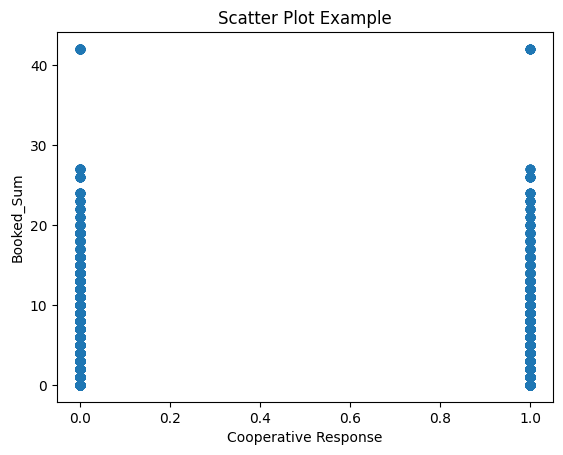

In [26]:
##Assumption Checks 
###Power Analysis 5, Booked_Sum vs Cooperative Response
Visible_Minority_AD = df['Actions_at_arrest___Cooperative']
result = anderson(Visible_Minority_AD)
print('Statistic:', result.statistic)
print('Critical Values:', result.critical_values)
print('Significance Level:', result.significance_level)


#Homogeneity of Variance
# Using Levene's test to check equal variance
# Small p-value suggests not equal variance
group0 = df.loc[df['Actions_at_arrest___Cooperative'] == 0, 'Booked_Sum'].dropna()
group1 = df.loc[df['Actions_at_arrest___Cooperative'] == 1, 'Booked_Sum'].dropna()
stat, p = levene(group0, group1)
print("Levene's Test p-value:", p)

In [27]:
###Power Analysis 1, Booked_Sum vs Visible Minority
group1 = df.loc[df['Visible_Minority'] == 0, 'Booked_Sum']
group2 = df.loc[df['Visible_Minority'] == 1, 'Booked_Sum']
group1

0        3
1        3
13       0
23       1
25       1
        ..
65266    0
65269    0
65270    0
65271    0
65273    0
Name: Booked_Sum, Length: 29652, dtype: int64

In [28]:
#conduct power analysis vs Visible_Minority
from statsmodels.stats.power import TTestIndPower
effect_size = Cohens_d(group1,group2)
alpha = 0.05
power = 0.8
ratio_ =len(group1)/len(group2) #NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for period 3 grades:',effect_size)

Effect size (Cohen's D) for period 3 grades: 0.15979651715556717


In [29]:
#vs Visible Minority_Immigrant
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for group1')
print('Actual size of group1:', len(group1))
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for group2') 
print('Actual size of group2:', len(group2))
     

Sample Size of nobs2: 706.365 needed for group1
Actual size of group1: 29652
Sample Size of nobs1: 545.663 needed for group2
Actual size of group2: 22906


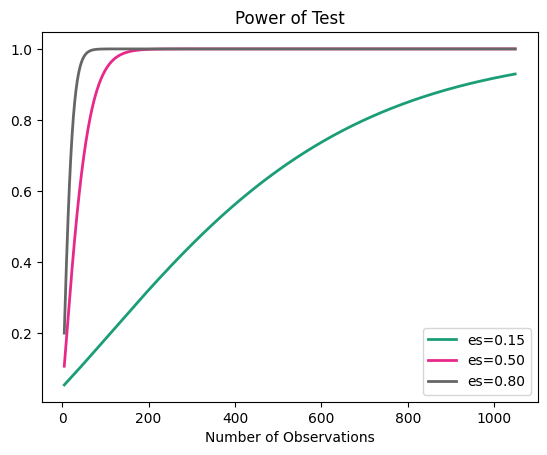

In [30]:
#Power curve 1
effect_sizes = np.array([0.15, 0.5, 0.8])
sample_sizes = np.array(range(5, 1049))
  
# plot power curves
analysis.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)
  
plt.show()

In [31]:
#Power Analysis 2, Booked_Sum vs Resisted_Arrest
median_booked_sum = df['Booked_Sum'].median()
group1 = df.loc[df['Booked_Sum'] <= median_booked_sum, 'Resisted_Arrest']
group2 = df.loc[df['Booked_Sum'] > median_booked_sum, 'Resisted_Arrest']
group1

13       0
22       0
23       0
24       0
25       0
        ..
65271    1
65272    0
65273    0
65274    0
65275    0
Name: Resisted_Arrest, Length: 37563, dtype: int64

In [32]:
#conduct power analysis vs Resisted_Arrest
from statsmodels.stats.power import TTestIndPower
effect_size = Cohens_d(group1,group2)
alpha = 0.05
power = 0.8
ratio_ =len(group1)/len(group2) #NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for period 3 grades:',effect_size)

Effect size (Cohen's D) for period 3 grades: -0.23773703335414395


In [33]:
#vs Resisted_Arrest
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for group1')
print('Actual size of group1:', len(group1))
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for group2') 
print('Actual size of group2:', len(group2))
     

Sample Size of nobs2: 328.272 needed for group1
Actual size of group1: 37563
Sample Size of nobs1: 242.112 needed for group2
Actual size of group2: 27704


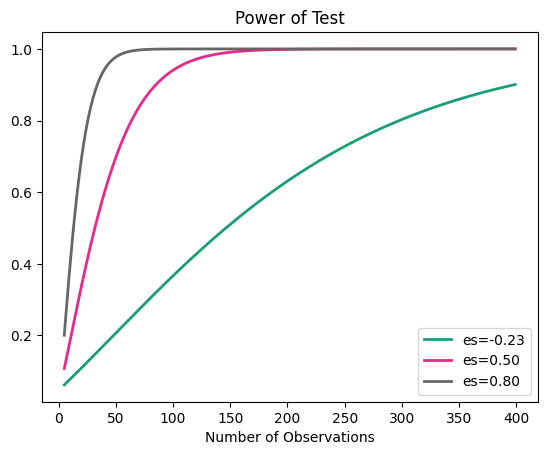

In [34]:
#Power curve 2
effect_sizes = np.array([-0.23, 0.5, 0.8])
sample_sizes = np.array(range(5, 400))
  
# plot power curves
analysis.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)
  
plt.show()

In [35]:
#Power Analysis 3, Booked_Sum vs Age
group1 = df.loc[df['Booked_Sum'] <= median_booked_sum, 'Age']
group2 = df.loc[df['Booked_Sum'] > median_booked_sum, 'Age']
group1

13       5.0
22       5.0
23       3.0
24       3.0
25       4.0
        ... 
65271    3.0
65272    4.0
65273    5.0
65274    1.0
65275    2.0
Name: Age, Length: 37563, dtype: float64

In [36]:
#conduct power analysis vs Age
from statsmodels.stats.power import TTestIndPower
effect_size = Cohens_d(group1,group2)
alpha = 0.05
power = 0.8
ratio_ =len(group1)/len(group2) #NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for period 3 grades:',effect_size)

Effect size (Cohen's D) for period 3 grades: 0.01957592718484186


In [37]:
#vs Age
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for group2') 
print('Actual size of group2:', len(group2))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for group1')
print('Actual size of group1:', len(group1))
     

Sample Size of nobs1: 35588.138 needed for group2
Actual size of group2: 27704
Sample Size of nobs2: 48252.860 needed for group1
Actual size of group1: 37563


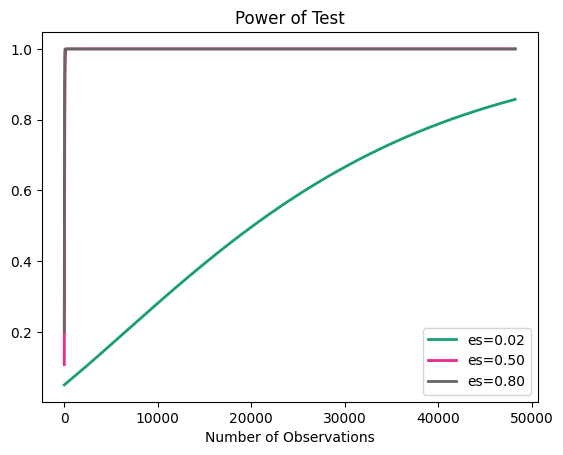

In [38]:
#Power curve 3
effect_sizes = np.array([0.0195, 0.5, 0.8])
sample_sizes = np.array(range(5, 48253))
  
# plot power curves
analysis.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)
  
plt.show()

In [39]:
#Power Analysis 4, Booked_Sum vs Gender
group1 = df.loc[df['Gender'] == 0, 'Booked_Sum']
group2 = df.loc[df['Gender'] == 1, 'Booked_Sum']
group1

34        0
41        1
42       12
43       12
44       12
         ..
65252     1
65263     1
65270     0
65271     0
65273     0
Name: Booked_Sum, Length: 12617, dtype: int64

In [40]:
#conduct power analysis vs Gender
from statsmodels.stats.power import TTestIndPower
effect_size = Cohens_d(group1,group2)
alpha = 0.05
power = 0.8
ratio_ =len(group1)/len(group2) #NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for period 3 grades:',effect_size)

Effect size (Cohen's D) for period 3 grades: -0.12020748352372718


In [41]:
#vs Gender
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for group1')
print('Actual size of group1:', len(group1))
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for group2') 
print('Actual size of group2:', len(group2))

     

Sample Size of nobs2: 673.718 needed for group1
Actual size of group1: 12617
Sample Size of nobs1: 2811.387 needed for group2
Actual size of group2: 52650


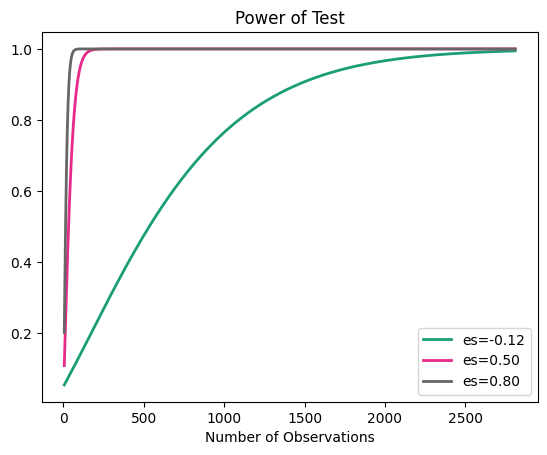

In [42]:
#Power curve 4
effect_sizes = np.array([-0.12, 0.5, 0.8])
sample_sizes = np.array(range(5, 2812))
  
# plot power curves
analysis.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)
  
plt.show()

In [43]:
#Power Analysis 5, Booked_Sum vs Cooperative Response
group1 = df.loc[df['Actions_at_arrest___Cooperative'] == 0, 'Booked_Sum']
group2 = df.loc[df['Actions_at_arrest___Cooperative'] == 1, 'Booked_Sum']
group1

1        3
2        3
3        2
4        2
6        4
        ..
65269    0
65270    0
65271    0
65272    1
65273    0
Name: Booked_Sum, Length: 36161, dtype: int64

In [44]:
#conduct power analysis vs Cooperative Response
from statsmodels.stats.power import TTestIndPower
effect_size = Cohens_d(group1,group2)
alpha = 0.05
power = 0.8
ratio_ =len(group1)/len(group2) #NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for period 3 grades:',effect_size)

Effect size (Cohen's D) for period 3 grades: 0.12223962203615002


In [45]:
#vs Cooperative Response
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for group1')
print('Actual size of group1:', len(group1))
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for group2') 
print('Actual size of group2:', len(group2))
     

Sample Size of nobs2: 1178.925 needed for group1
Actual size of group1: 36161
Sample Size of nobs1: 948.917 needed for group2
Actual size of group2: 29106


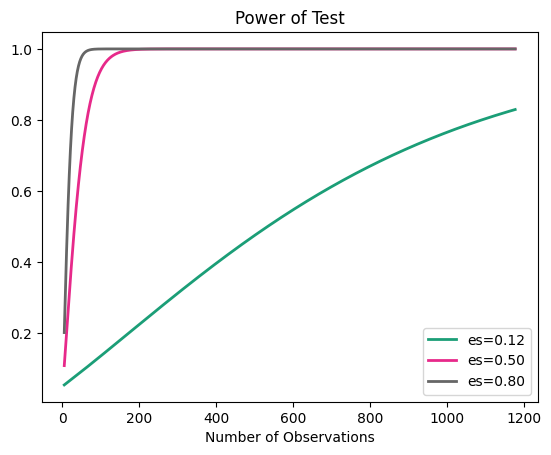

In [46]:
#Power curve 5
effect_sizes = np.array([0.12, 0.5, 0.8])
sample_sizes = np.array(range(5, 1179))
  
# plot power curves
analysis.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)
  
plt.show()

In [47]:
##ANCOVA

In [48]:
# Perform the ANCOVA

model = ols('Booked_Sum~ Occurrence_Category + Visible_Minority + Resisted_Arrest + Gender', data=df).fit()

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Booked_Sum   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     420.5
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:09:34   Log-Likelihood:            -1.4277e+05
No. Observations:               52424   AIC:                         2.856e+05
Df Residuals:                   52419   BIC:                         2.856e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

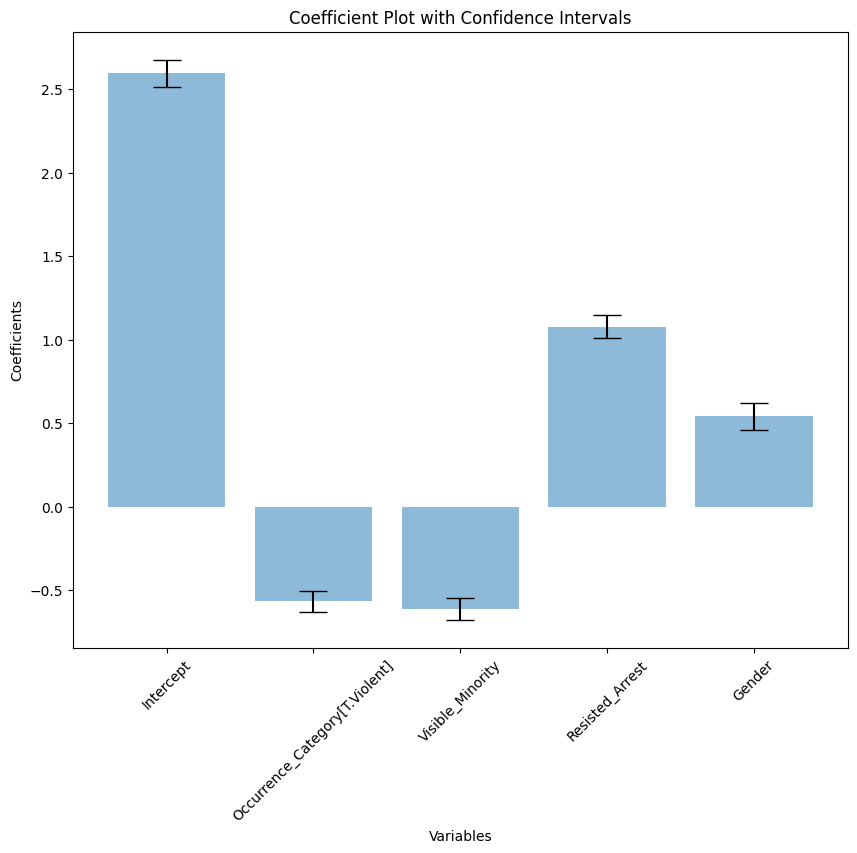

In [49]:
coefs = model.params
conf_int = model.conf_int()
errors = coefs - conf_int[0]

plt.figure(figsize=(10, 8))
plt.bar(range(len(coefs)), coefs, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(range(len(coefs)), coefs.index, rotation=45)
plt.xlabel('Variables')
plt.ylabel('Coefficients')
plt.title('Coefficient Plot with Confidence Intervals')
plt.show()


In [50]:
###Logistic Regression

In [51]:
x = df[['Actions_at_arrest___Cooperative', 'Occurrence_Category', 'Visible_Minority','Sex','Resisted_Arrest']]
y = df['Booked']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=123)
all_columns = ' + '.join(x.columns)
formula = "Booked ~ " + all_columns
print("Formula: ", formula, "\n")
trainingdata = pd.concat([x_train, y_train], axis=1)

Formula:  Booked ~ Actions_at_arrest___Cooperative + Occurrence_Category + Visible_Minority + Sex + Resisted_Arrest 



In [52]:
log_reg = smf.logit(formula, data=trainingdata).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.673830
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Booked   No. Observations:                39317
Model:                          Logit   Df Residuals:                    39311
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Apr 2023   Pseudo R-squ.:                 0.02346
Time:                        00:09:35   Log-Likelihood:                -26493.
converged:                       True   LL-Null:                       -27130.
Covariance Type:            nonrobust   LLR p-value:                4.147e-273
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4090      0.028    -14.455  

In [53]:
#getting odds ratio 
np.exp(log_reg.params)

Intercept                          0.664309
Occurrence_Category[T.Violent]     1.012898
Sex[T.M]                           1.487099
Actions_at_arrest___Cooperative    1.303876
Visible_Minority                   1.068217
Resisted_Arrest                    2.324775
dtype: float64

In [54]:
params = log_reg.params
conf = log_reg.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)

,Lower CI,Upper CI,OR
Intercept,0.628470,0.702191,0.664309
Occurrence_Category[T.Violent],0.972834,1.054612,1.012898
Sex[T.M],1.414262,1.563687,1.487099
Actions_at_arrest___Cooperative,1.251160,1.358813,1.303876
Visible_Minority,1.025543,1.112667,1.068217
Resisted_Arrest,2.191076,2.466633,2.324775


In [55]:
pred_1 = log_reg.predict(x_test)
pred_1 = [p if not np.isnan(p) else 0 for p in pred_1]
prediction_1 = list(map(round, pred_1))

print('\nTest accuracy = ', accuracy_score(y_test, prediction_1))


Test accuracy =  0.5547588404731262


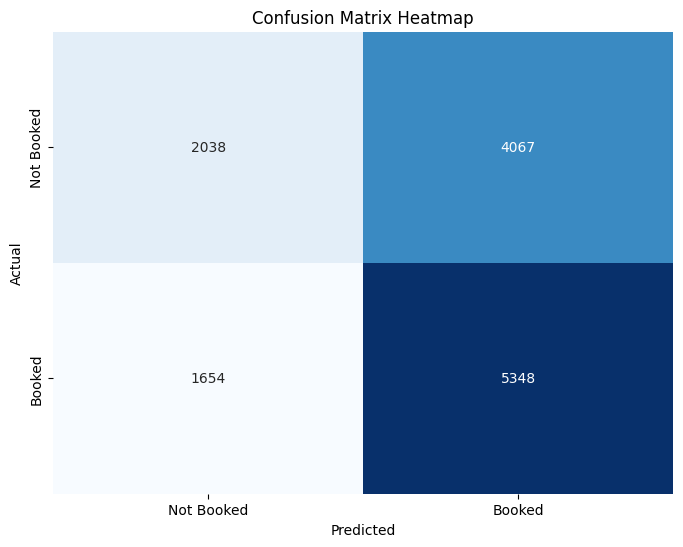

In [56]:
pred = log_reg.predict(x_test)
pred_df = pd.DataFrame({'predictions': pred, 'y_test': y_test})
pred_df = pred_df.dropna(subset=['predictions'])
prediction = [round(p) for p in pred_df['predictions']]
cm = confusion_matrix(pred_df['y_test'], prediction)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Booked', 'Booked'], yticklabels=['Not Booked', 'Booked'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [57]:
#cannot make prediction interval for some reason so i made a booked ~ resisted arrest
X = sm.add_constant(df['Resisted_Arrest'])
y = df['Booked']
model = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.681467
         Iterations 5


In [58]:
β_ = model.params.values.reshape(-1, 1)
V_ = model.cov_params().values

Λ = lambda x: stats.logistic().cdf(x)
λ = lambda x: stats.logistic().pdf(x)

In [59]:
def var_π(x, β, V_):
    prob = λ(x.T.dot(β))**2 * x.T.dot(V_).dot(x)
    return prob

In [60]:
def var_πs(xx, β, V_):
    α = λ(xx.dot(β))**2
    out = np.empty((len(xx), 1))
    for i, x in enumerate(xx):
        out[i] = x.T.dot(V_).dot(x)
    return α * out

In [61]:
resisted_arrest_values = np.arange(5).reshape(-1, 1)
xx = sm.add_constant(resisted_arrest_values)

πs = Λ(xx.dot(β_))
vv = np.sqrt(var_πs(xx, β_, V_))

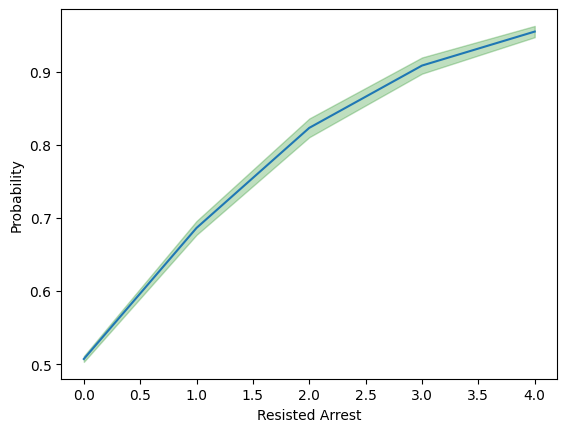

In [62]:
plt.plot(resisted_arrest_values, πs)
plt.fill_between(resisted_arrest_values.ravel(), (πs - 1.96*vv).ravel(), (πs + 1.96*vv).ravel(),
                 alpha=.25, color='g')
plt.xlabel('Resisted Arrest')
plt.ylabel('Probability')
plt.show()